In [1]:
%matplotlib inline
import rebound as r
r.reset()
import numpy as np
import matplotlib.pyplot as plt
r.status()
from IPython.html.widgets import interact, interactive
from IPython.display import display

---------------------------------
Rebound version:     	1.1.0
Build on:            	Jun 21 2015 16:09:56
Number of particles: 	0
Simulation time:     	0.000000
---------------------------------


:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Simulated data:

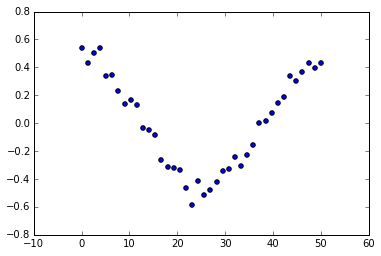

In [2]:
data_N = 40
data_t = np.linspace(0.,50.,data_N)+0.0005*np.random.rand(data_N)
data_rv = 0.500883379885605*(np.sin(2.*np.pi*data_t/50.+np.pi/2.)+0.4*(np.random.rand(data_N)-0.5))
plt.scatter(data_t, data_rv);

## Setting up simulations

In [5]:
for k in range(4):
    print varid2(0,k)

11
13
15
17


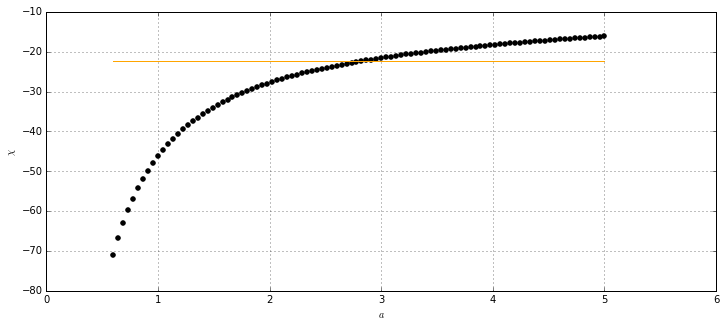

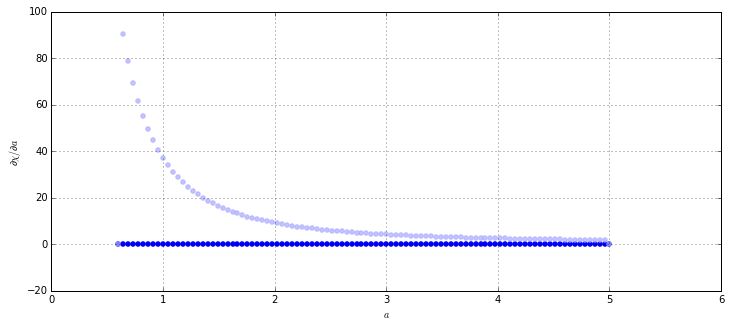

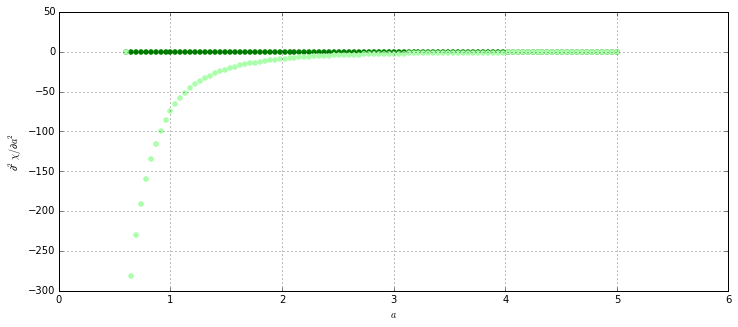

In [11]:
numvar = 4
N = 2
def varid2(l,k):
    if k>l:
        raise Exception("error")
    if l>=numvar:
        raise Exception("error")
    var = l*(l+1)/2+k
    return var*N+1+N+N*numvar
def varid1(l):
    if l>=numvar:
        raise Exception("error")
    return N*l+1+N
    
def simulation(cart):
    r.reset()
    r.N_megnopp = numvar 
    r.add(m=1.)
    op = r.Particle(a=cart[1],e=cart[0],anom=cart[2],omega=cart[3])
    r.add(op)
    N = r.N
    r.init_megno(0.)
    ps = r.particles
    
    
    delta = 1e-4
    # First order
    for l in range(numvar):
        cart2 = cart.copy()
        cart2[l] += delta/2.
        mp = r.Particle(primary=ps[0],a=cart2[1],e=np.clip(cart2[0],0.,0.9),anom=cart2[2],omega=cart2[3])
        cart2 = cart.copy()
        cart2[l] -= delta/2.
        mm = r.Particle(primary=ps[0],a=cart2[1],e=np.clip(cart2[0],0.,0.9),anom=cart2[2],omega=cart2[3])

        vari = varid1(l)
        ps[vari].x  = (mp.x  - mm.x  )
        ps[vari].y  = (mp.y  - mm.y  )
        ps[vari].z  = (mp.z  - mm.z  )
        ps[vari].vx = (mp.vx - mm.vx )
        ps[vari].vy = (mp.vy - mm.vy )
        ps[vari].vz = (mp.vz - mm.vz )
        
    # Second order
    for l in range(numvar):
        for k in range(l+1):
            fac = 2.
            cart2 = cart.copy()
            cart2[l] += delta/fac
            cart2[k] += delta/fac
            mpp = r.Particle(primary=ps[0],a=cart2[1],e=np.clip(cart2[0],0.,0.9),anom=cart2[2],omega=cart2[3])
            cart2 = cart.copy()
            cart2[l] += delta/fac
            cart2[k] -= delta/fac
            mpm = r.Particle(primary=ps[0],a=cart2[1],e=np.clip(cart2[0],0.,0.9),anom=cart2[2],omega=cart2[3])
            cart2 = cart.copy()
            cart2[l] -= delta/fac
            cart2[k] += delta/fac
            mmp = r.Particle(primary=ps[0],a=cart2[1],e=np.clip(cart2[0],0.,0.9),anom=cart2[2],omega=cart2[3])
            cart2 = cart.copy()
            cart2[l] -= delta/fac
            cart2[k] -= delta/fac
            mmm = r.Particle(primary=ps[0],a=cart2[1],e=np.clip(cart2[0],0.,0.9),anom=cart2[2],omega=cart2[3])
            
            vari2 = varid2(l,k)
            ps[vari2].x  = mpp.x  - mpm.x  - mmp.x  + mmm.x
            ps[vari2].y  = mpp.y  - mpm.y  - mmp.y  + mmm.y 
            ps[vari2].z  = mpp.z  - mpm.z  - mmp.z  + mmm.z 
            ps[vari2].vx = mpp.vx - mpm.vx - mmp.vx + mmm.vx
            ps[vari2].vy = mpp.vy - mpm.vy - mmp.vy + mmm.vy
            ps[vari2].vz = mpp.vz - mpm.vz - mmp.vz + mmm.vz
    
    
    ##################################################################
    # INTEGRATION
    logp    = 0.
    logp_d  = np.zeros(numvar)
    logp_d2 = np.zeros((numvar*(numvar+1)/2,2))
    for i,t in enumerate(data_t):
        r.integrate(t)
        dv = ps[1].vx-data_rv[i]
        logp  += -dv**2
        for k in range(numvar):
            vari1 = varid1(k)
            logp_d[k] += -2.*ps[vari1].vx/delta * dv
        _id = 0
        for l in range(numvar):
            for k in range(l+1):
                vari2 = varid2(l,k)
                vari1l = varid1(l)
                vari1k = varid1(k)
                logp_d2[_id][0] += -2.*(ps[vari1l].vx * ps[vari1k].vx)/(delta*delta)
                logp_d2[_id][1] += -2.*(ps[vari2].vx * dv)/(delta*delta)
                _id += 1
    
    logp_d2m = np.zeros((numvar,numvar))
    _id = 0
    for l in range(numvar):
        for k in range(l+1):
            fdd = logp_d2[_id][0] + logp_d2[_id][1]
            logp_d2m[l,k] = fdd
            logp_d2m[k,l] = fdd
            _id +=1
    
    return logp, logp_d, logp_d2m
a0 = np.array([4.0,4.,0.,-np.pi/2.]) # initial parameters
a = a0.copy()

N_grid = 100
a_s = np.linspace(0.6,5,N_grid)
#a_s = np.linspace(3.0,6.0,N_grid)

errs = np.zeros(N_grid)
gradients = np.zeros(N_grid)
hessians = np.zeros(N_grid)

for i,at in enumerate(a_s):
    a[1] = at
    err, gradient, hessian = simulation(a)
    errs[i] = err
    gradients[i] = gradient[0]
    lasthessian = hessian
    hessians[i] = hessian[0,0]
    

        
def widget_plot(ind):
    ind = int(ind)
  
    def f(a,i):
        da = a - a_s[i] 
        return errs[i] + gradients[i]*da,  errs[i] + gradients[i]*da + 0.5*hessians[i]*da*da
    
    a_s_fine = np.linspace(a_s[0],a_s[-1],N_grid*10)
    err_fine = np.zeros(N_grid*10)
    err_fine2 = np.zeros(N_grid*10)
    for i,a in enumerate(a_s_fine):
        err_fine[i], err_fine2[i] = f(a,ind)
        
    gradient_direct = np.zeros(N_grid)
    hessian_direct  = np.zeros(N_grid)
    for i,a in enumerate(a_s_fine):
        if i>0 and i<N_grid-1:
            gradient_direct[i] = (errs[i+1]-errs[i-1])/(a_s[i+1]-a_s[i-1])
            hessian_direct[i]  = (errs[i+1]-2.*errs[i]+errs[i-1])/((a_s[i+1]-a_s[i])*(a_s[i]-a_s[i-1]))
            
 
    fig1 = plt.figure(figsize=(12,5))
    plt.ylabel("$\chi$"); plt.xlabel("$a$")
    plt.scatter(a_s, errs, color="k");   
    plt.plot(a_s_fine, err_fine, color="r");
    plt.plot(a_s_fine, err_fine2, color="#FFA500");
    plt.grid()
    
    fig2 = plt.figure(figsize=(12,5))
    plt.ylabel("${\partial \chi}/{\partial a}$"); plt.xlabel("$a$")
    plt.scatter(a_s, gradients, color="b");
    plt.scatter(a_s, gradient_direct, color="#aaaaff",alpha=0.7);
    plt.grid()
    
    
    fig3 = plt.figure(figsize=(12,5))
    plt.ylabel("${\partial^2 \chi}/{\partial a^2}$"); plt.xlabel("$a$")
    plt.scatter(a_s, hessians, color="g");
    plt.scatter(a_s, hessian_direct, color="#aaffaa");
    plt.grid()

w = interactive(widget_plot, ind=(0,N_grid))

display(w)

In [72]:
print lasthessian

[[ 2.77266804 -1.51219508 -2.52335042 -2.66691865]
 [-1.51219508 -5.59881756 -5.5649794  -0.1088305 ]
 [-2.52335042 -5.5649794   0.64813316  0.8340711 ]
 [-2.66691865 -0.1088305   0.8340711   0.93882481]]


In [73]:
print np.linalg.eig(-lasthessian)[0]

[ 9.41513739 -6.17102672  0.79832962 -2.80324873]


In [74]:
print np.linalg.cholesky(-lasthessian)

LinAlgError: Matrix is not positive definite

In [23]:
np.linalg.cholesky(np.array([[1,1,0],[1,7,0],[0,0,1]]))

array([[ 1.        ,  0.        ,  0.        ],
       [ 1.        ,  2.44948974,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])